## SRGAN

Here I built a SR model that will super resolve the low resoluted image.In this overall implementation i trained SRRESNET model first with mse optimization and then i followed GAN approach for further optimization using this trained SSRESNET with perceptual loss optimization.

# Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing dependencies

In [ ]:
# file handling
import os
import shutil
from PIL import Image

#visualization
from matplotlib import pyplot as plt

# tensorflow
import numpy as np
import tensorflow  as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Add,
    LeakyReLU,
    Flatten,
    Dense
)
from tensorflow.keras import Model

# progress tracking
from tqdm import tqdm


In [ ]:
# moving to the desired directory
os.chdir("/content/drive/MyDrive/superresolution")

## Data Preparation

In this section we are,

<ul>
  <li> Downloading the dataset</li>
  <li> Making the proper directory structure for the data</li>
  <li> Forming datasets for train,val and test
  </li>
</ul>

In [ ]:
# Here for the training i am using COCO14 dataset
# for the testing SET14,SET5,BSDS100

# COCO14  link : http://images.cocodataset.org/zips/train2014.zip (training)(85,000 images)
# SET12,SET5,BSDS100 link :  https://github.com/XPixelGroup/BasicSR/blob/master/docs/DatasetPreparation.md#common-image-sr-datasets

# If you didnt download the dataset , by visiting the above link download the required dataset

# directory structure
# ./data
#     train/
#           training images
#     test/
#           testing images

# move all the coco images to ./data/train/  ( here i used only 10k coco images due to storage constraints)
# move all the SET14,SET5,BSDS100 to ./data/test/


SET14 = 'Set14/original'
SET5 = 'Set5/original'
BSDS100 = 'BSDS100'
TRAINPATH = '/content/drive/MyDrive/superresolution/data/train'
TESTPATH = '/content/drive/MyDrive/superresolution/data/test'
# for testpath in [SET14,SET5,BSDS100]:
#   for imgpath in os.listdir(testpath):
#     shutil.move(os.path.join(testpath,imgpath),os.path.join(TESTPATH,imgpath))

In [ ]:

len(os.listdir(TRAINPATH))

10984

In [ ]:
os.listdir(TESTPATH)

['37073.png',
 '19021.png',
 '66053.png',
 '69015.png',
 '62096.png',
 '21077.png',
 '54082.png',
 '55073.png',
 '42012.png',
 '14037.png',
 '76053.png',
 '85048.png',
 '86000.png',
 '41033.png',
 '65033.png',
 '33039.png',
 '45096.png',
 '43074.png',
 '12084.png',
 '42049.png',
 '38082.png',
 '24077.png',
 '58060.png',
 '78004.png',
 '41069.png',
 '3096.png',
 '16077.png',
 '69020.png',
 '69040.png',
 '8023.png',
 '38092.png',
 '119082.png',
 '182053.png',
 '105025.png',
 '148089.png',
 '101085.png',
 '197017.png',
 '87046.png',
 '160068.png',
 '167083.png',
 '108082.png',
 '86016.png',
 '175032.png',
 '189080.png',
 '108005.png',
 '145086.png',
 '97033.png',
 '167062.png',
 '147091.png',
 '106024.png',
 '143090.png',
 '109053.png',
 '163085.png',
 '210088.png',
 '216081.png',
 '170057.png',
 '148026.png',
 '89072.png',
 '123074.png',
 '108070.png',
 '208001.png',
 '103070.png',
 '196073.png',
 '175043.png',
 '130026.png',
 '134035.png',
 '86068.png',
 '102061.png',
 '157055.png',
 '1

In [ ]:

# filtering the images which has width and height greater than 100 as
#we need to randomly crop the image of size 96x96
# and then downsample the image by a factor of 4 (24x24)

trainimgpath = []
for imgpath in os.listdir(TRAINPATH):
  if imgpath.endswith('.jpg'):
    img = Image.open(os.path.join(TRAINPATH,imgpath))
    if img.width > 100 and img.height > 100 and img.mode == 'RGB':
      trainimgpath.append(os.path.join(TRAINPATH,imgpath))

In [ ]:
# no of training images
n_traindata = len(trainimgpath)
n_traindata

10959

In [ ]:
rng = tf.random.Generator.from_seed(123, alg='philox')
scale = tf.constant(4)

@tf.function
def trainpreprocess(imgpath):
  # reading the image
  img = tf.image.decode_jpeg(tf.io.read_file(imgpath))
  # normalizing the image to have values in range(0,1)
  img = tf.image.convert_image_dtype(img,dtype=tf.float32)
  # making a seed
  seed = rng.make_seeds(2)[0]
  # randomly cropping the images
  hr = tf.image.stateless_random_crop(img,size=[96,96,3],seed=seed)
  # downsampling the image
  lr = tf.image.resize(hr,size = [24,24],antialias = True,method='bicubic')
  return  hr,lr

@tf.function
  def testpreprocess(valpath):

    # for the test images , we need to randomly crop the image with  the maximum possible
    # dimension divisible by 4
    img = tf.image.decode_png(tf.io.read_file(valpath))
    img_shape= tf.shape(img)
    height = img_shape[0]
    width = img_shape[1]


    # normalizing the image to have values in range(0,1)
    img = tf.image.convert_image_dtype(img,dtype=tf.float32)

    x_remainder = tf.math.floormod(x = width,y = 4)
    y_remainder = tf.math.floormod(x = height,y = 4)

    left = tf.math.floordiv(x_remainder,2)
    top = tf.math.floordiv(y_remainder,2)
    right = left+(width-x_remainder)
    bottom = top + (height-y_remainder)

    # crop the image of maximum possible dimension
    hr= img[top:bottom,left:right,:]

    lr_height = tf.math.floordiv(height,4)
    lr_width = tf.math.floordiv(width,4)

    # resize the image for lower resolution
    lr = tf.image.resize(hr,size=[lr_height,lr_width],antialias=True,method='bicubic')

    return hr,lr


In [ ]:


n_testimages = len(os.listdir(TESTPATH))

dataset = tf.data.Dataset.from_tensor_slices(trainimgpath)

#  traindataset
train_ds = dataset.take(round(n_traindata*0.9)) # 90 % of the overall training data
train_ds = train_ds.shuffle(buffer_size=10000)
train_ds = train_ds.map(trainpreprocess,num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(16)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.repeat()

# validation dataset
val_ds = dataset.skip(round(n_traindata*0.9)) # 10 % of the remaining training data
val_ds = val_ds.shuffle(buffer_size=1000)
val_ds = val_ds.map(trainpreprocess,num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(8)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


# test dataset
test_ds = tf.data.Dataset.list_files(os.path.join(TESTPATH,'*.png'))
test_ds = test_ds.shuffle(buffer_size = n_testimages)
test_ds = test_ds.map(testpreprocess,num_parallel_calls = tf.data.AUTOTUNE)



# Visualization of train dataset

here we can see the high resolution images on the left and its corresponding low resolution images on the right

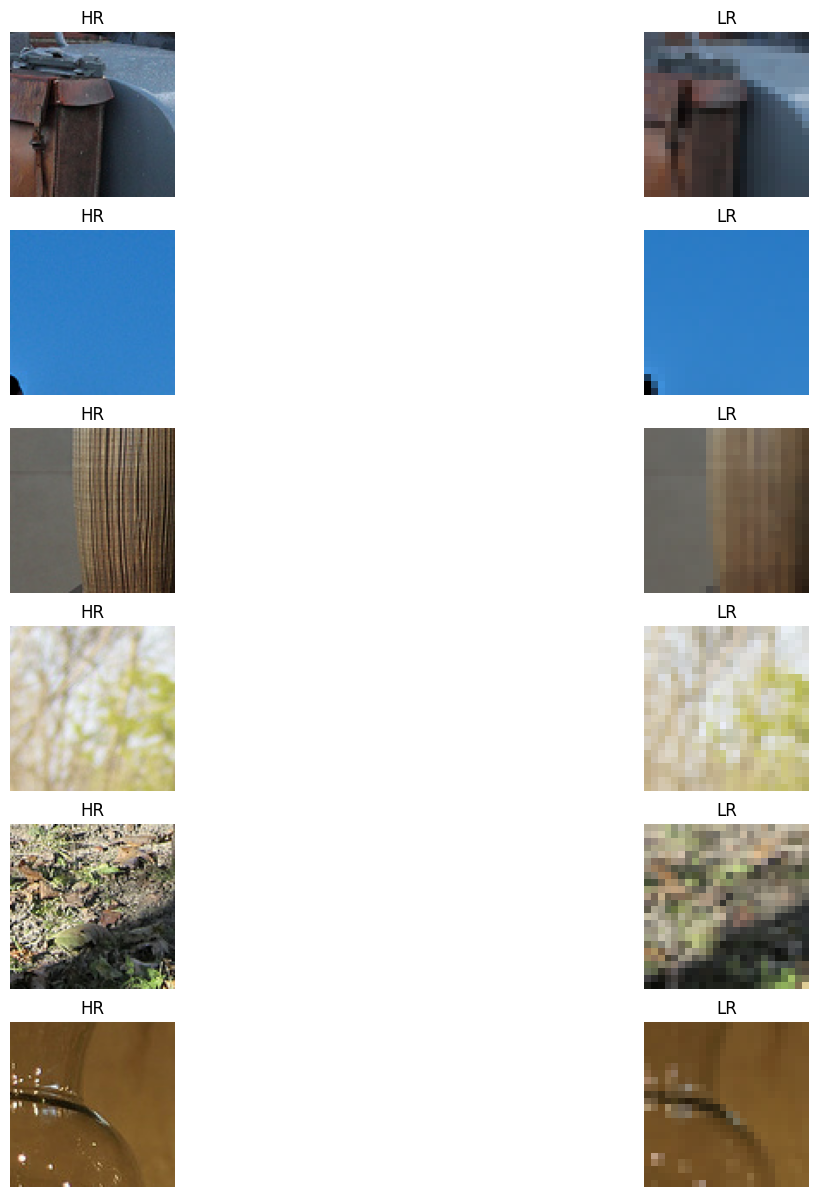

In [ ]:
viz = train_ds.as_numpy_iterator().next()

hr = viz[0]
lr = viz[1]
plt.figure(figsize=(15,15))

index = 1

for i in range(6):
  plt.subplot(6,2,index)
  plt.imshow(hr[i])
  plt.axis('off')
  plt.title('HR')
  index+=1

  plt.subplot(6,2,index)
  plt.imshow(lr[i])
  plt.axis('off')
  plt.title('LR')
  index+=1


## SRRESNET Model

<li> A fully convolutional network that upscale the image by 4x </li>
<li>It comprised of 16 residual blocks and 2 sub-pixel blocks </li>
<li>Initially a single convolution layer with  9x9 channel is used for increasing the channels to 64 and activated with LeakyRelu</li>
<li>16 Residual blocks where each contains two convolution layers </li>
<li> 2 Subpixel blocks used to upscale the feature maps,where each  block will upscale the image by a factor of 2</li>
<li> Final convolution block is used to reduce the channel size to 3 activated by sigmoid</li>

In [ ]:
def Resnet(input):

  x = Conv2D(64,kernel_size=3,strides=1,padding='same')(input)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)

  x = Conv2D(64,kernel_size=3,strides=1,padding='same')(x)
  x = BatchNormalization()(x)

  # skip connection
  x = Add()([input,x])

  return x


In [ ]:
def Subpixel(input):
  # increasing the depth of the channels as per the factor that we want to upscale the img
  x = Conv2D(256,kernel_size=3,strides=1,padding='same')(input)
  # pixel rearranging from depth to the pixel blocks
  x = tf.nn.depth_to_space(x,2)
  x = LeakyReLU(0.2)(x)
  return x

In [ ]:
def ResidualBlock(input_shape=(None,None,3),filters=64):
  input = Input(shape=input_shape,name='input')
  # initial convolution , increase the channel size to 64 , width and height maintained till subpixel block
  conv2d_1 = Conv2D(64,kernel_size=9,strides=1,padding='same')(input)
  skip = conv2d_1 = LeakyReLU(0.2)(conv2d_1)

  # 16 residual blocks
  i = 16
  while(i):
    if(i == 16):
       res_block = Resnet(conv2d_1)
    else :
       res_block = Resnet(res_block)
    i-=1


  conv2d_2 = Conv2D(64,kernel_size=9,strides=1,padding='same')(res_block)
  conv2d_2 = BatchNormalization()(conv2d_2)

  add_1 = Add()([skip,conv2d_2])

  # 2 subpixel block
  subpixel_1 = Subpixel(add_1)
  subpixel_2 = Subpixel(subpixel_1)

  # final convolution
  conv2d_3 = Conv2D(3,kernel_size=9,strides=1,padding='same')(subpixel_2)
  output = tf.keras.activations.sigmoid(conv2d_3)

  return Model(inputs=input, outputs =output ,name='ResidualBlock')


In [ ]:
residual = ResidualBlock()

In [ ]:
residual.summary()

Model: "ResidualBlock"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   15616       ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, None, None,   0           ['conv2d[0][0]']                 
                                64)                                                   

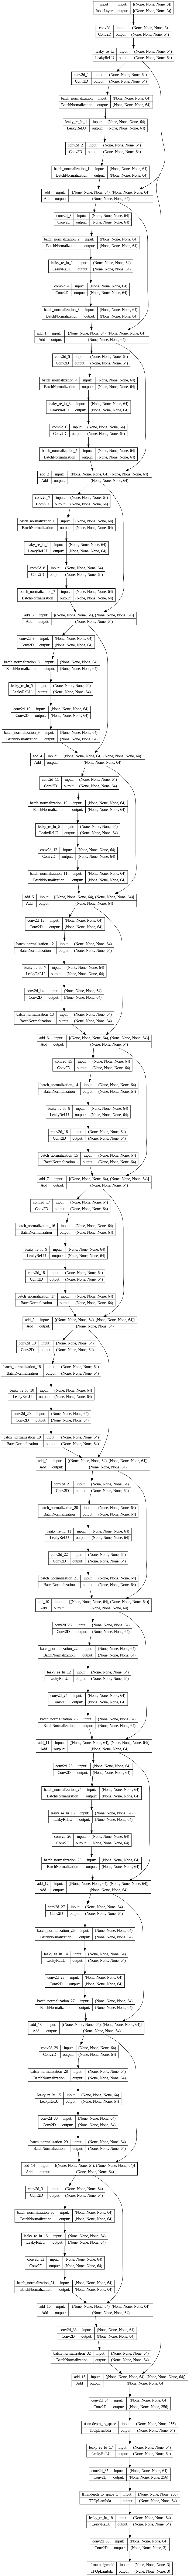

In [ ]:
tf.keras.utils.plot_model(residual,'residual.png',show_shapes=True)

## Model configuration

<li> Here model is trained for 1 million iterations</li>
<li> MSE loss is used for computing the loss between the super resolved and the high resolution images </li>
<li> Learning scheduler is used for decaying learning rate at consequent boundary iterations </li>

In [ ]:
# Learning Rate scheduler - 1e-4 (first 100000) , 1e-5(100000 - 500000) , 1e06 (500000 above)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries = [100000,500000], values = [1e-4,1e-5,1e-6])

mse = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

# Training and Evaluation - SRRESNET

In [ ]:
@tf.function
def train_step(hr,lr):
  with tf.GradientTape() as tape:
    # forward pass
    sr = residual(lr,training=True)
    # mse on the image
    loss = mse(hr,sr)
  # calculating gradient of loss w.r.t srresnet parameters
  grad = tape.gradient(loss,residual.trainable_variables)
  # updating the model parameters with the gradients
  opt.apply_gradients(zip(grad,residual.trainable_variables))

  # ssim and psnr between the high resolution and the super resoluted image
  ssim = tf.image.ssim(hr,sr,max_val=1)
  psnr = tf.image.psnr(hr,sr,max_val=1)

  return loss,ssim,psnr


@tf.function
def test_step(hr,lr):
  sr = residual(lr,training=False)
  loss = mse(hr,sr)

  ssim = tf.image.ssim(hr,sr,max_val=1)
  psnr = tf.image.psnr(hr,sr,max_val=1)

  return loss,ssim,psnr



In [ ]:
 # meter class for tracking the state of PSNR and SSIM , loss metric during the training
class meter(object):

  def __init__(self):
    self.reset()

  def update(self,metric,type='metric'):

    if(type=='loss'):
      self.count+=1
      self.val += metric.numpy()
    else :
      self.count += len(metric.numpy())
      self.val += metric.numpy().sum()
    self.avg = self.val/self.count


  def reset(self):
    self.val = 0
    self.avg = 0
    self.count = 0


In [ ]:
psnr_meter = meter()
ssim_meter = meter()
t_loss_meter = meter()
v_loss_meter = meter()

In [ ]:
checkpointpath = 'checkpoints/residual'
modelpath = 'models/residual'


# checkpoint to save the state of the model ,opt and step
checkpoint = tf.train.Checkpoint(step = tf.Variable(0,name='step'),
                                 model = residual,
                                 optimizer = opt)

manager = tf.train.CheckpointManager(checkpoint = checkpoint,
                                     directory = checkpointpath,
                                     max_to_keep = 3)

if manager.latest_checkpoint:
      checkpoint.restore(manager.latest_checkpoint)
      residual.save(modelpath)
      print('[*] load ckpt from {} at step {}.'.format(manager.latest_checkpoint, checkpoint.step.numpy()))
else:
      print("[*] training from scratch.")


total_iter = 1e6 # one million iteration
n_batchinepoch = round(round(n_traindata*0.9)/16) # no of batches in a single epoch

rem_iter = max(total_iter -checkpoint.step.numpy(),0) # interations remaining in the overall training
pbar = tqdm(total = rem_iter,ncols=200)

t_loss = []
v_loss = []
t_psnr = []
v_psnr = []
t_ssim = []
v_ssim = []



for hr,lr in train_ds.take(rem_iter):
  # updating the step
  checkpoint.step.assign_add(1)
  step = checkpoint.step.numpy()

  # trainstep
  (loss,ssim,psnr) = train_step(hr,lr)

  # tracking metrics
  psnr_meter.update(psnr)
  ssim_meter.update(ssim)
  t_loss_meter.update(loss,'loss')

  # progress bar
  pbar.set_description(f' train_loss : {loss} learning_rate : {opt.learning_rate.numpy()} ssim : {ssim_meter.avg} psnr : {psnr_meter.avg} step:{step}')
  pbar.update(1)

  if(step % n_batchinepoch == 0):  # for each batch validation is carried out for evaluating the model performance

    t_loss.append(t_loss_meter.avg)
    t_psnr.append(psnr_meter.avg)
    t_ssim.append(ssim_meter.avg)

    psnr_meter.reset()
    ssim_meter.reset()
    t_loss_meter.reset()

    print('\n')
    print('\n')
    for hr,lr in val_ds:

      (val_loss,val_ssim,val_psnr) = test_step(hr,lr)

      psnr_meter.update(val_psnr)
      ssim_meter.update(val_ssim)
      v_loss_meter.update(val_loss,'loss')

    print("------------validation results -------------------------------------\n")
    print(f'val_loss : {loss}  psnr:{psnr_meter.avg} ssim: {ssim_meter.avg}')
    print('---------------------------------------------------------------------\n')

    v_loss.append(v_loss_meter.avg)
    v_psnr.append(psnr_meter.avg)
    v_ssim.append(ssim_meter.avg)

    psnr_meter.reset()
    ssim_meter.reset()
    v_loss_meter.reset()

    manager.save()

    print(f'saved checkpoint file {manager.latest_checkpoint}')

residual.save(modelpath)


# Visualization of the loss, psnr and ssim metrics

In [ ]:


x = np.arange(0,len(t_loss))

plt.figure(figsize= (30,30))
for i,metric in enumerate(['loss','psnr','ssim']):
  if(metric =='loss'):
    plt.subplot(3,1,i+1)
    plt.plot(x,t_loss,color='red',label='train_loss')
    plt.plot(x,v_loss,color='orange',label='val_loss',linestyle='--')
    plt.xlabel('interations')
    plt.ylabel(metric)
  elif(metric=='psnr'):
    plt.subplot(3,1,i+1)
    plt.plot(x,t_psnr,color='green',label='train_psnr')
    plt.plot(x,v_psnr,color='red',label='val_psnr',linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(metric)
  elif (metric=='ssim'):
    plt.subplot(3,1,i+1)
    plt.plot(x,t_ssim,color='blue',label='train_ssim')
    plt.plot(x,v_ssim,color='red',label='val_ssim',linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(metric)






# SRRESNET on testdataset

In [ ]:
residual = tf.keras.models.load_model(modelpath)

tpsnr_meter = meter()
tssim_meter = meter()
test_loss_meter = meter()

for hr,lr in test_ds:
  hr = tf.expand_dims(hr,axis=0)
  lr = tf.expand_dims(lr,axis=0)
  loss,ssim,psnr = test_step(hr,lr)
  test_loss_meter.update(loss,'loss')
  tpsnr_meter.update(psnr)
  tssim_meter.update(ssim)

print(f"Testing :----: loss : {test_loss_meter.avg}  pnsr : {tpsnr_meter.avg}   ssim : {tssim_meter.avg}")


# Visualization of the predicted SR image on test dataset - SRRESNET

In [ ]:
viz = test_ds.as_numpy_iterator()

fig = plt.figure(figsize=(10,10))

index = 1

for i in range(6):
  hr,lr = viz.next()
  lr_ = tf.expand_dims(lr,axis=0)
  sr = residual(lr_)
  sr = tf.squeeze(sr)
  plt.subplot(6,3,index)
  plt.imshow(hr)
  plt.axis('off')
  plt.title('HR')
  index+=1


  plt.subplot(6,3,index)
  plt.imshow(sr)
  plt.axis('off')
  plt.title('SR')
  index+=1

  plt.subplot(6,3,index)
  plt.imshow(lr)
  plt.axis('off')
  plt.title('LR')
  index+=1


fig.suptitle(' VISUALIZATION  OF HIGH RESOLUTION  AND PREDICTED SUPER RESOLUTION')

# GAN TRAINING

<li> Here the previously trained SRRESNET is used as a generator optimized with VGG19 mse as perceptual loss is more aligned with the human perception and provide better performance compared to the mse</li>
<li> A Discriminator a binary classifier that determines if a high resolution image is natural or artificial origin </li>
<li> Discriminator block that contains 7 convolution block following batch normalization and LeakyRelu </li>
<li>Output from the convolution is flattened and fully connected to form a single output activated with sigmoid predicting the probability of the input image being natural or artificial origin</li>

In [ ]:
# convolution  block contains 7 convolutions
def convolutionblock(input):
  channels = 64
  i = 7
  x = input
  while(i):
    if(i%2==0):
      channels *=2
      x = Conv2D(channels,kernel_size=3,strides=1,padding='same')(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.2)(x)
    else:
      x = Conv2D(channels,kernel_size=3,strides=2,padding='same')(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.2)(x)
    i-=1

  return x


In [ ]:

def discriminator(input_shape=(None,None,3)):

  input = Input(shape=input_shape)
  x = Conv2D(64,kernel_size=9,strides=1,padding='same')(input)
  x = LeakyReLU(0.2)(x)

  x = convolutionblock(x)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  x = Dense(1024)(x)
  x = LeakyReLU(0.2)(x)

  x = Dense(1,activation = 'sigmoid')(x)

  return Model(inputs = input,outputs=x)


In [ ]:
disc = discriminator()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 64)    15616     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, None, None, 64)    0         
                                                                 
 conv2d_38 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 batch_normalization_33 (Bat  (None, None, None, 64)   256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, None, None, 64)    0         
                                                             

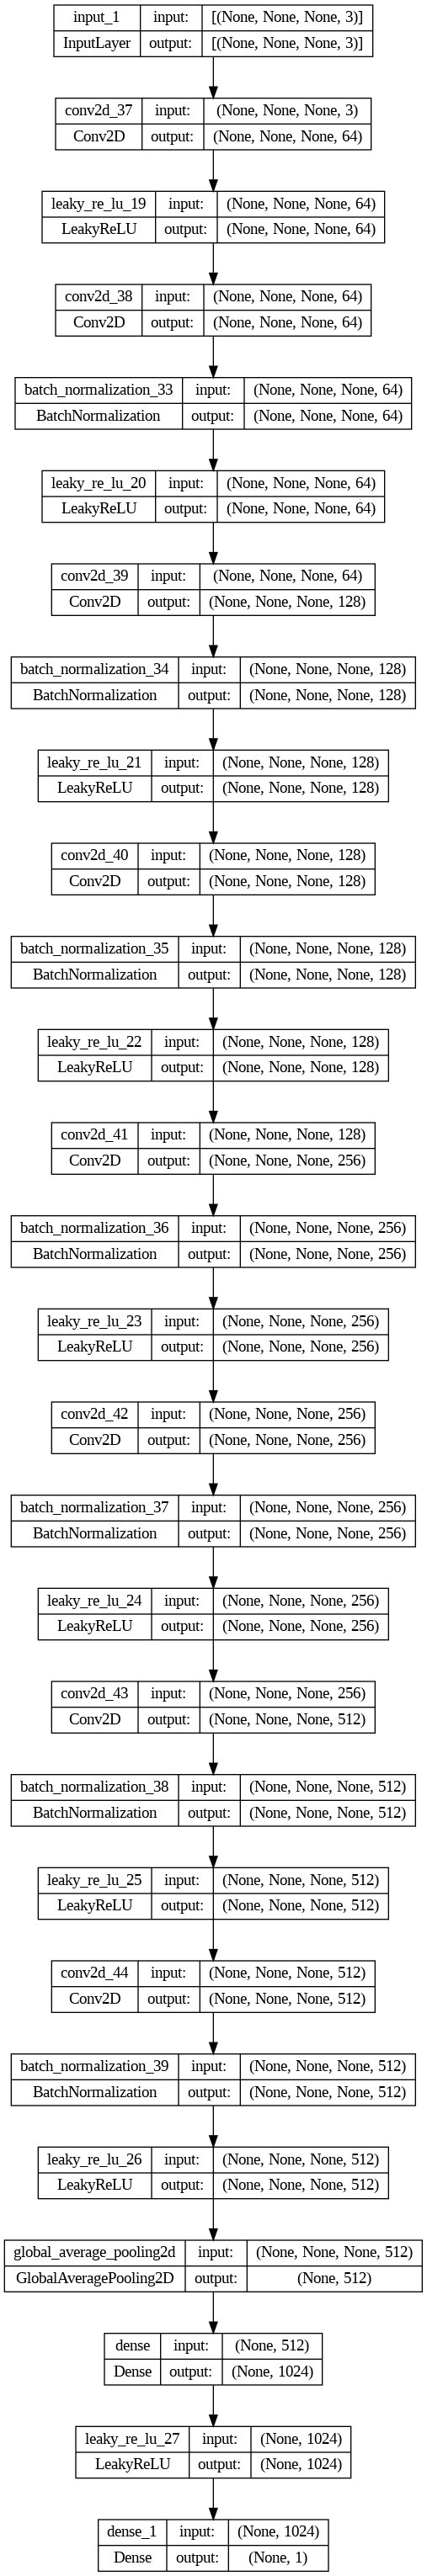

In [ ]:
disc.summary()
tf.keras.utils.plot_model(disc,'discriminator.png',show_shapes=True)

In [ ]:

from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input


# vgg19 network
vgg = VGG19(input_shape=(None,None,3),include_top=False,weights='imagenet')

# truncate the model as per our need
vgg = tf.keras.Model(vgg.input,vgg.layers[15].output,trainable=False)

mse = tf.keras.losses.MeanSquaredError()

@tf.function
def content_loss(hr,lr):
  # preprocess_input function  will preprocess the input image in suitable format for VGG16( normalizing pixel values with  imagenet mean and std)
  lr  = preprocess_input(lr*255.0)/12.75
  hr = preprocess_input(hr*255.0)/12.75
  # forward pass
  vgg_lr = vgg(lr)
  vgg_hr = vgg(hr)

  return mse(vgg_hr,vgg_lr)


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# As i am GAN training for 0.2 million steps , for the first 0.1 million(lr  = 1e-4) and then (lr=1e-5)
lr_scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [1e5],values=[1e-4,1e-5])

opt_g = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
opt_d = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

In [ ]:
n_iterations = 2e5

In [ ]:
crossentropy = tf.keras.losses.BinaryCrossentropy()

@tf.function
def gan_train_step(hr,lr):
  # Generator and discriminator is trained alternatively
  with tf.GradientTape() as tape:
    sr = residual(lr)
    sr_prob = disc(sr)
              # vgg feature mse loss        #classification loss (generater want the sr image to predicted as real)
    g_loss = content_loss(hr,sr) + crossentropy(tf.ones_like(sr_prob),sr_prob)

  # updating the generator parameters
  g_grad = tape.gradient(g_loss,residual.trainable_variables)
  opt_g.apply_gradients(zip(g_grad,residual.trainable_variables))


  with tf.GradientTape() as tape:
    hr_prob = disc(hr)
    sr_prob = disc(sr)
              # classification loss for hr( truth = one )          # classification loss for sr (truth = zeros)
    d_loss = crossentropy(tf.ones_like(hr_prob),hr_prob) + crossentropy(tf.zeros_like(sr_prob),sr_prob)

  # updating the disc parameters
  d_grad = tape.gradient(d_loss,disc.trainable_variables)
  opt_d.apply_gradients(zip(d_grad,disc.trainable_variables))

  ssim = tf.image.ssim(hr,sr,max_val=1)
  psnr = tf.image.psnr(hr,sr,max_val=1)

  return g_loss,d_loss,ssim,psnr


@tf.function
def gan_test_step(hr,lr):
  sr = residual(lr)
  sr_prob = disc(sr)
  g_loss = content_loss(hr,sr) + crossentropy(tf.ones_like(sr_prob),sr_prob)

  hr_prob = disc(hr)
  sr_prob = disc(sr)
  d_loss = crossentropy(tf.ones_like(hr_prob),hr_prob) + crossentropy(tf.zeros_like(sr_prob),sr_prob)

  ssim = tf.image.ssim(hr,sr,max_val=1)
  psnr = tf.image.psnr(hr,sr,max_val=1)

  return g_loss,d_loss,ssim,psnr

In [ ]:

checkpointpath = 'checkpoints/gan'
gmodelpath = 'models/gan/residual'
dmodelpath = 'models/gan/disc'

# saving the step , residual,disc model and optimizer states
gan_checkpoint = tf.train.Checkpoint(step = tf.Variable(0,name='step'),
                                 g_model = residual,
                                 d_model = disc,
                                 opt_d = opt_d,
                                 opt_g = opt_g)

gan_manager = tf.train.CheckpointManager(checkpoint = gan_checkpoint,
                                     directory = checkpointpath,
                                     max_to_keep = 3)

if gan_manager.latest_checkpoint:
      gan_checkpoint.restore(gan_manager.latest_checkpoint)
      print('[*] load ckpt from {} at step {}.'.format(
          gan_manager.latest_checkpoint, gan_checkpoint.step.numpy()))
else:
      # checkpoint.restore(manager.latest_checkpoint)
      print('[*] training from scratch')
# The Gan training is done for 2lakh iterations with learning rate of 1e-4 for the first 100000 iterations and
# 1e-5 for the next 100000 iterations
n_iterations = 2e5
n_batchinepoch = round(round(n_traindata*0.9)/16) # no of batches in a single epoch

rem_iterations = max(n_iterations-gan_checkpoint.step.numpy(),0)

pbar = tqdm(total=rem_iterations,ncols=250)

total_gt_loss = []
total_dt_loss = []

total_gv_loss = []
total_dv_loss = []

total_t_psnr = []
total_t_ssim = []
total_v_psnr = []
total_v_ssim = []

g_loss_meter = meter()
d_loss_meter = meter()


for hr,lr in train_ds.take(rem_iterations):

  gan_checkpoint.step.assign_add(1)
  step = gan_checkpoint.step.numpy()
  # forward pass
  gt_loss,dt_loss,t_ssim,t_psnr = gan_train_step(hr,lr)

  # updating the psnr and ssim state
  psnr_meter.update(t_psnr)
  ssim_meter.update(t_ssim)
  g_loss_meter.update(gt_loss,'loss')
  d_loss_meter.update(dt_loss,'loss')

  pbar.set_description(f'train_generator_loss : {gt_loss} | train_discriminator_loss : {dt_loss} | psnr : {psnr_meter.avg} | ssim : {ssim_meter.avg} | step : {step} ')
  pbar.update(1)

  if(step %n_batchinepoch == 0):
    # validation step
     # tracking the metric for each batch
    total_gt_loss.append(g_loss_meter.avg)
    total_dt_loss.append(d_loss_meter.avg)
    total_t_psnr.append(psnr_meter.avg)
    total_t_ssim.append(ssim_meter.avg)

    psnr_meter.reset()
    ssim_meter.reset()
    g_loss_meter.reset()
    d_loss_meter.reset()

    for hr,lr in val_ds:
      # forward pass
      gv_loss,dv_loss,v_ssim,v_psnr = gan_test_step(hr,lr)
      # updating the psnr and ssim state for the current batch
      psnr_meter.update(v_psnr)
      ssim_meter.update(v_ssim)
      g_loss_meter.update(gv_loss,'loss')
      d_loss_meter.update(dv_loss,'loss')

    print('\n')
    print('\n')
    print('--------------valdiation results-----------------------')
    print(f'val_generator_loss : {gv_loss} | val_discriminator_loss : {dv_loss} | psnr : {psnr_meter.avg} | ssim : {ssim_meter.avg}')
    print('-------------------------------------------------------')

    total_gv_loss.append(g_loss_meter.avg)
    total_dv_loss.append(d_loss_meter.avg)
    total_v_psnr.append(psnr_meter.avg)
    total_v_ssim.append(ssim_meter.avg)

    psnr_meter.reset()
    ssim_meter.reset()
    g_loss_meter.reset()
    d_loss_meter.reset()


    gan_manager.save()
    print(f'saved checkpoint file {gan_manager.latest_checkpoint}')

residual.save(gmodelpath)
disc.save(dmodelpath)

[*] load ckpt from checkpoints/gan/ckpt-296 at step 182336.


train_generator_loss : 100.65282440185547 | train_discriminator_loss : 0.4997994005680084 | psnr : 24.782164456008317 | ssim : 0.628619546191646 | step : 182952 :   3%|█▍                                        | 616/17664.0 [06:31<1:21:26,  3.49it/s]





--------------valdiation results-----------------------
val_generator_loss : 90.08140563964844 | val_discriminator_loss : 0.07676681876182556 | psnr : 25.796567346057753 | ssim : 0.6724351605359655
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-297


train_generator_loss : 112.53919219970703 | train_discriminator_loss : 0.3295277953147888 | psnr : 24.841839846613638 | ssim : 0.6289434055271422 | step : 183568 :   7%|██▊                                     | 1232/17664.0 [09:38<1:09:08,  3.96it/s]





--------------valdiation results-----------------------
val_generator_loss : 113.02328491210938 | val_discriminator_loss : 0.10528111457824707 | psnr : 25.664868570592283 | ssim : 0.6681489346236208
-------------------------------------------------------


train_generator_loss : 93.80148315429688 | train_discriminator_loss : 0.47023826837539673 | psnr : 23.414464950561523 | ssim : 0.5741368532180786 | step : 183569 :   7%|██▋                                    | 1233/17664.0 [09:52<19:07:32,  4.19s/it]

saved checkpoint file checkpoints/gan/ckpt-298


train_generator_loss : 72.51630401611328 | train_discriminator_loss : 0.21046942472457886 | psnr : 24.80148797971265 | ssim : 0.6286663804984497 | step : 184184 :  10%|████▎                                    | 1848/17664.0 [12:35<1:07:35,  3.90it/s]





--------------valdiation results-----------------------
val_generator_loss : 91.56552124023438 | val_discriminator_loss : 0.5037427544593811 | psnr : 25.875370192701798 | ssim : 0.6691375714148918
-------------------------------------------------------


train_generator_loss : 76.72222137451172 | train_discriminator_loss : 0.13415740430355072 | psnr : 26.003286361694336 | ssim : 0.6841384172439575 | step : 184185 :  10%|████                                   | 1849/17664.0 [12:49<18:54:33,  4.30s/it]

saved checkpoint file checkpoints/gan/ckpt-299


train_generator_loss : 108.27308654785156 | train_discriminator_loss : 0.16035358607769012 | psnr : 24.82059722587374 | ssim : 0.6296247435521629 | step : 184800 :  14%|█████▌                                  | 2464/17664.0 [15:30<1:12:56,  3.47it/s]





--------------valdiation results-----------------------
val_generator_loss : 102.45365905761719 | val_discriminator_loss : 0.6322703957557678 | psnr : 25.58815938016794 | ssim : 0.6721521548546143
-------------------------------------------------------


train_generator_loss : 114.89522552490234 | train_discriminator_loss : 0.22856281697750092 | psnr : 23.802364349365234 | ssim : 0.6089459657669067 | step : 184801 :  14%|█████▍                                 | 2464/17664.0 [15:49<1:12:56,  3.47it/s]

saved checkpoint file checkpoints/gan/ckpt-300


train_generator_loss : 98.34133911132812 | train_discriminator_loss : 0.05325279384851456 | psnr : 24.74467622755602 | ssim : 0.6275003746437932 | step : 185416 :  17%|███████▏                                 | 3080/17664.0 [18:28<1:00:32,  4.02it/s]





--------------valdiation results-----------------------
val_generator_loss : 92.09478759765625 | val_discriminator_loss : 0.20757123827934265 | psnr : 26.084376801539513 | ssim : 0.6741598526926806
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-301


train_generator_loss : 111.34243774414062 | train_discriminator_loss : 0.3301700949668884 | psnr : 24.787749148582193 | ssim : 0.6271805920624619 | step : 186032 :  21%|████████▎                               | 3696/17664.0 [21:23<1:00:20,  3.86it/s]





--------------valdiation results-----------------------
val_generator_loss : 59.745933532714844 | val_discriminator_loss : 0.29712533950805664 | psnr : 25.63095896087424 | ssim : 0.6725017983112892
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-302


train_generator_loss : 102.43224334716797 | train_discriminator_loss : 0.03849313035607338 | psnr : 24.816169054626606 | ssim : 0.627469620463012 | step : 186648 :  24%|██████████▎                               | 4312/17664.0 [24:16<56:25,  3.94it/s]





--------------valdiation results-----------------------
val_generator_loss : 69.43419647216797 | val_discriminator_loss : 0.1736108511686325 | psnr : 25.619209971741167 | ssim : 0.6669936915383722
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-303


train_generator_loss : 99.26310729980469 | train_discriminator_loss : 0.16859397292137146 | psnr : 24.808097956349332 | ssim : 0.627676415397417 | step : 187264 :  28%|███████████▉                               | 4928/17664.0 [27:11<53:37,  3.96it/s]





--------------valdiation results-----------------------
val_generator_loss : 71.97828674316406 | val_discriminator_loss : 0.1888750046491623 | psnr : 25.691637442929903 | ssim : 0.6733347164453382
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-304


train_generator_loss : 94.72061157226562 | train_discriminator_loss : 0.18860533833503723 | psnr : 24.733324156468974 | ssim : 0.6253085641482281 | step : 187880 :  31%|█████████████▏                            | 5544/17664.0 [30:04<51:21,  3.93it/s]





--------------valdiation results-----------------------
val_generator_loss : 51.92373275756836 | val_discriminator_loss : 0.06343936175107956 | psnr : 25.709314151401937 | ssim : 0.6662639466515423
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-305


train_generator_loss : 110.7853775024414 | train_discriminator_loss : 0.025111906230449677 | psnr : 24.84262943897342 | ssim : 0.6288733392775306 | step : 188496 :  35%|██████████████▋                           | 6160/17664.0 [33:00<48:53,  3.92it/s]





--------------valdiation results-----------------------
val_generator_loss : 130.05320739746094 | val_discriminator_loss : 0.21947793662548065 | psnr : 25.591900915995133 | ssim : 0.6703205039031315
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-306


train_generator_loss : 74.19070434570312 | train_discriminator_loss : 0.15262797474861145 | psnr : 24.754800845514495 | ssim : 0.6282725664907584 | step : 189112 :  38%|████████████████                          | 6776/17664.0 [35:52<44:59,  4.03it/s]





--------------valdiation results-----------------------
val_generator_loss : 107.05007934570312 | val_discriminator_loss : 0.0049154190346598625 | psnr : 25.791218346922935 | ssim : 0.6735614235818821
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-307


train_generator_loss : 104.2079849243164 | train_discriminator_loss : 0.14442864060401917 | psnr : 24.81377390666554 | ssim : 0.629440697096345 | step : 189728 :  42%|██████████████████▍                         | 7392/17664.0 [38:48<44:21,  3.86it/s]





--------------valdiation results-----------------------
val_generator_loss : 165.23130798339844 | val_discriminator_loss : 0.09209588170051575 | psnr : 25.62428034483081 | ssim : 0.6614851444742106
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-308


train_generator_loss : 102.39542388916016 | train_discriminator_loss : 0.1710267961025238 | psnr : 24.75928730604866 | ssim : 0.6257615735885079 | step : 190344 :  45%|███████████████████▍                       | 8008/17664.0 [41:41<40:15,  4.00it/s]





--------------valdiation results-----------------------
val_generator_loss : 82.48242950439453 | val_discriminator_loss : 0.0966196209192276 | psnr : 25.540441067549434 | ssim : 0.6698329124572503
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-309


train_generator_loss : 101.13724517822266 | train_discriminator_loss : 0.28098365664482117 | psnr : 24.770550269650556 | ssim : 0.6273839135478447 | step : 190960 :  49%|████████████████████                     | 8624/17664.0 [44:36<37:57,  3.97it/s]





--------------valdiation results-----------------------
val_generator_loss : 117.54177856445312 | val_discriminator_loss : 0.1751215010881424 | psnr : 25.528137694310097 | ssim : 0.6692983129598798
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-310


train_generator_loss : 71.9208984375 | train_discriminator_loss : 0.13280418515205383 | psnr : 24.804206579291083 | ssim : 0.6293592693673253 | step : 191576 :  52%|████████████████████████                      | 9240/17664.0 [47:29<37:47,  3.72it/s]





--------------valdiation results-----------------------
val_generator_loss : 98.40938568115234 | val_discriminator_loss : 0.016391810029745102 | psnr : 25.636114941896313 | ssim : 0.6774453077003033
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-311


train_generator_loss : 114.54825592041016 | train_discriminator_loss : 0.028349822387099266 | psnr : 24.792773824277063 | ssim : 0.6284120864186346 | step : 192192 :  56%|██████████████████████▎                 | 9856/17664.0 [50:23<33:38,  3.87it/s]





--------------valdiation results-----------------------
val_generator_loss : 92.21611022949219 | val_discriminator_loss : 0.11324536800384521 | psnr : 25.77170236963425 | ssim : 0.6755741177684199
-------------------------------------------------------


train_generator_loss : 121.77786254882812 | train_discriminator_loss : 0.1615716516971588 | psnr : 23.132410049438477 | ssim : 0.6026686429977417 | step : 192193 :  56%|█████████████████████▊                 | 9857/17664.0 [50:40<11:08:52,  5.14s/it]

saved checkpoint file checkpoints/gan/ckpt-312


train_generator_loss : 83.38268280029297 | train_discriminator_loss : 0.059106454253196716 | psnr : 24.72448066935341 | ssim : 0.6260441670360161 | step : 192808 :  59%|████████████████████████▎                | 10472/17664.0 [53:16<30:05,  3.98it/s]





--------------valdiation results-----------------------
val_generator_loss : 77.05878448486328 | val_discriminator_loss : 0.021966923028230667 | psnr : 25.614911364812922 | ssim : 0.6709709676512836
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-313


train_generator_loss : 101.47239685058594 | train_discriminator_loss : 0.3462858200073242 | psnr : 24.712227751715506 | ssim : 0.6261705329506073 | step : 193424 :  63%|█████████████████████████▋               | 11088/17664.0 [56:11<27:50,  3.94it/s]





--------------valdiation results-----------------------
val_generator_loss : 50.08488082885742 | val_discriminator_loss : 0.059673942625522614 | psnr : 25.689270994088947 | ssim : 0.6733564125360364
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-314


train_generator_loss : 107.6019287109375 | train_discriminator_loss : 0.18622951209545135 | psnr : 24.74946145167796 | ssim : 0.628366798413663 | step : 194040 :  66%|████████████████████████████▍              | 11704/17664.0 [59:04<24:42,  4.02it/s]





--------------valdiation results-----------------------
val_generator_loss : 55.30465316772461 | val_discriminator_loss : 0.23834441602230072 | psnr : 25.700286656400582 | ssim : 0.6673548739321911
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-315


train_generator_loss : 97.73065948486328 | train_discriminator_loss : 0.17509891092777252 | psnr : 24.732219728198864 | ssim : 0.6279596364279018 | step : 194656 :  70%|███████████████████████████▏           | 12320/17664.0 [1:01:58<22:30,  3.96it/s]





--------------valdiation results-----------------------
val_generator_loss : 43.70049285888672 | val_discriminator_loss : 0.03531336784362793 | psnr : 25.63105134894378 | ssim : 0.6711845106452051
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-316


train_generator_loss : 88.44386291503906 | train_discriminator_loss : 0.5703749060630798 | psnr : 24.735538441214548 | ssim : 0.6283319566145008 | step : 195272 :  73%|█████████████████████████████▎          | 12936/17664.0 [1:04:51<19:34,  4.03it/s]





--------------valdiation results-----------------------
val_generator_loss : 75.57518768310547 | val_discriminator_loss : 0.1512761414051056 | psnr : 25.799201519819942 | ssim : 0.6777162591036219
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-317


train_generator_loss : 66.22103881835938 | train_discriminator_loss : 0.6944345235824585 | psnr : 24.795401366989154 | ssim : 0.6294834413564276 | step : 195888 :  77%|██████████████████████████████▋         | 13552/17664.0 [1:07:46<17:39,  3.88it/s]





--------------valdiation results-----------------------
val_generator_loss : 97.77804565429688 | val_discriminator_loss : 0.03130164369940758 | psnr : 25.666493311415625 | ssim : 0.6675979292740787
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-318


train_generator_loss : 101.63941955566406 | train_discriminator_loss : 0.04941525310277939 | psnr : 24.72461724690499 | ssim : 0.6274900239071072 | step : 196504 :  80%|███████████████████████████████▎       | 14168/17664.0 [1:10:38<15:15,  3.82it/s]





--------------valdiation results-----------------------
val_generator_loss : 120.87667083740234 | val_discriminator_loss : 0.006693874951452017 | psnr : 25.5847576447647 | ssim : 0.672374385986885
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-319


train_generator_loss : 74.95316314697266 | train_discriminator_loss : 0.06335540115833282 | psnr : 24.744861587674723 | ssim : 0.6266336719965806 | step : 197120 :  84%|████████████████████████████████▋      | 14784/17664.0 [1:13:32<15:06,  3.18it/s]





--------------valdiation results-----------------------
val_generator_loss : 69.66845703125 | val_discriminator_loss : 0.5353103280067444 | psnr : 25.42862957585467 | ssim : 0.6718963025695216
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-320


train_generator_loss : 75.41832733154297 | train_discriminator_loss : 0.2868691086769104 | psnr : 24.700713626307206 | ssim : 0.6260010845784404 | step : 197736 :  87%|██████████████████████████████████▊     | 15400/17664.0 [1:16:27<09:30,  3.97it/s]





--------------valdiation results-----------------------
val_generator_loss : 120.82859802246094 | val_discriminator_loss : 0.014855700545012951 | psnr : 25.64284672702316 | ssim : 0.6718576243759071
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-321


train_generator_loss : 112.9876480102539 | train_discriminator_loss : 0.034701038151979446 | psnr : 24.760078055950377 | ssim : 0.6285486500239243 | step : 198352 :  91%|██████████████████████████████████▍   | 16016/17664.0 [1:19:21<08:12,  3.35it/s]





--------------valdiation results-----------------------
val_generator_loss : 90.11473083496094 | val_discriminator_loss : 0.09103604406118393 | psnr : 25.60150973466191 | ssim : 0.669120307821427
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-322


train_generator_loss : 114.75968933105469 | train_discriminator_loss : 0.21419787406921387 | psnr : 24.686244426505315 | ssim : 0.6247306716518377 | step : 198968 :  94%|███████████████████████████████████▊  | 16632/17664.0 [1:22:17<04:18,  3.99it/s]





--------------valdiation results-----------------------
val_generator_loss : 112.91749572753906 | val_discriminator_loss : 0.14163891971111298 | psnr : 25.90738176777415 | ssim : 0.681056009591931
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-323


train_generator_loss : 94.2334213256836 | train_discriminator_loss : 0.09129776805639267 | psnr : 24.702399024409402 | ssim : 0.6268261443349544 | step : 199584 :  98%|███████████████████████████████████████ | 17248/17664.0 [1:25:10<01:46,  3.90it/s]





--------------valdiation results-----------------------
val_generator_loss : 121.18508911132812 | val_discriminator_loss : 0.12781541049480438 | psnr : 25.81190727400954 | ssim : 0.674547361631463
-------------------------------------------------------
saved checkpoint file checkpoints/gan/ckpt-324


train_generator_loss : 86.23228454589844 | train_discriminator_loss : 0.3133198916912079 | psnr : 24.654622364460266 | ssim : 0.6243528125697515 | step : 200000 : 100%|████████████████████████████████████████| 17664/17664.0 [1:27:14<00:00,  3.99it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


# Visualization of the loss, psnr and ssim metrics - GAN

In [ ]:
x = np.arange(0,len(total_gt_loss))

for i,metric in enumerate(['gen_loss','disc_loss','psnr','ssim']):
  if(metric =='gen_loss'):
    plt.subplot(3,1,i+1)
    plt.plot(x,total_gt_loss,color='red',label='train_gen_loss')
    plt.plot(x,total_gv_loss,color='orange',label='val_gen_loss',linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(metric)
  elif(metric=='gen_loss'):
    plt.subplot(3,1,i+1)
    plt.plot(x,total_dt_loss,color='red',label='train_disc_loss')
    plt.plot(x,total_dv_loss,color='orange',label='val_disc_loss',linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(metric)
  elif(metric=='psnr'):
    plt.subplot(3,1,i+1)
    plt.plot(x,t_psnr,color='green',label='train_psnr')
    plt.plot(x,v_psnr,color='yellow',label='val_psnr',linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(metric)
  elif (metric=='ssim'):
    plt.subplot(3,1,i+1)
    plt.plot(x,t_ssim,color='blue',label='train_ssim')
    plt.plot(x,v_ssim,color='yellow',label='val_ssim',linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(metric)



NameError: ignored

#  GAN model on Test dataset

In [ ]:
# residual = tf.keras.models.load_model(gmodelpath)


tpsnr_meter = meter()
tssim_meter = meter()
g_loss_meter = meter()
d_loss_meter = meter()

for hr,lr in test_ds:
  hr = tf.expand_dims(hr,axis=0)
  lr = tf.expand_dims(lr,axis=0)
  g_loss,d_loss,ssim,psnr = gan_test_step(hr,lr)
  tpsnr_meter.update(psnr)
  tssim_meter.update(ssim)
  g_loss_meter.update(g_loss,'loss')
  d_loss_meter.update(d_loss,'loss')
print(f"Testing :----: generator_loss : {g_loss_meter.avg} | discriminator_loss :{d_loss_meter.avg} | pnsr : {tpsnr_meter.avg}   ssim : {tssim_meter.avg}")

Testing :----: generator_loss : 57.997110422919775 | discriminator_loss :0.11604539297059856 | pnsr : 23.87769264734092   ssim : 0.6103724004591212


# Visualization of the predicted SR image on test dataset - GAN

In [ ]:
from tensorflow.keras.preprocessing.image import save_img

Text(0.5, 0.98, ' VISUALIZATION  OF HIGH RESOLUTION  AND PREDICTED SUPER RESOLUTION')

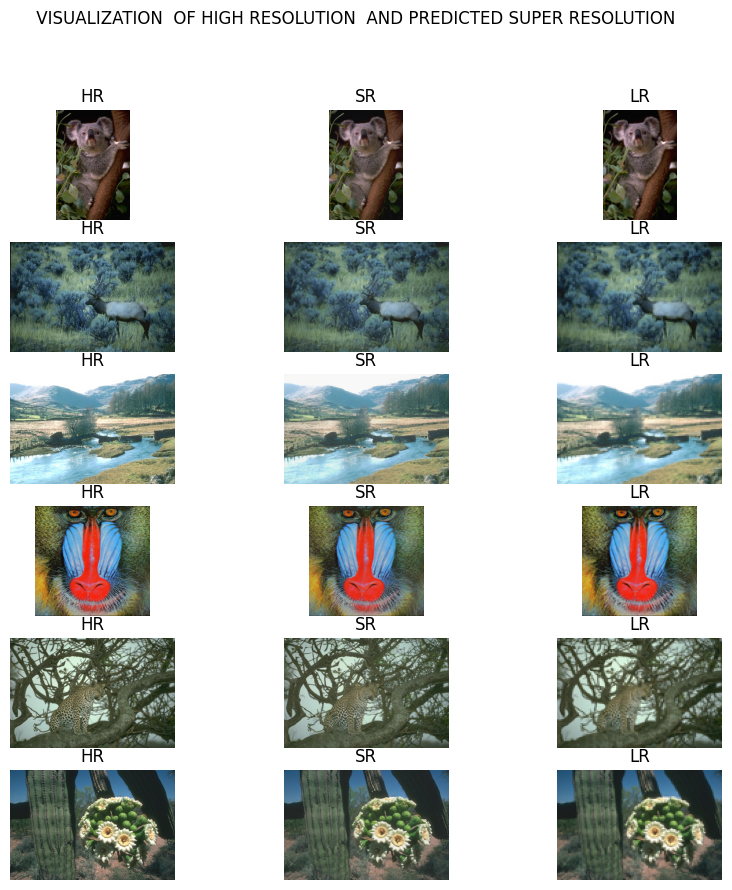

In [ ]:
viz = test_ds.as_numpy_iterator()

fig = plt.figure(figsize=(10,10))

index = 1

for i in range(6):
  hr,lr = viz.next()
  lr_ = tf.expand_dims(lr,axis=0)
  sr = residual(lr_)
  sr = tf.squeeze(sr)
  plt.subplot(6,3,index)
  plt.imshow(hr)
  plt.axis('off')
  plt.title('HR')
  index+=1


  plt.subplot(6,3,index)
  plt.imshow(sr)
  plt.axis('off')
  plt.title('SR')
  index+=1

  plt.subplot(6,3,index)
  plt.imshow(lr)
  plt.axis('off')
  plt.title('LR')
  index+=1
  save_img(os.path.join('ouputimg','sr'+str(i)+'.png'),sr)
  save_img(os.path.join('ouputimg','hr'+str(i)+'.png'),hr)
  save_img(os.path.join('ouputimg','lr'+str(i)+'.png'),lr)


fig.suptitle(' VISUALIZATION  OF HIGH RESOLUTION  AND PREDICTED SUPER RESOLUTION')

In [ ]:
str(1)

'1'